<h1>
<font color="#FA8072">Install Requirements</font>
</h1>

In [3]:
! pip install beautifulsoup4
! pip install requests
! pip install urllib3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h1>
<font color="#FA8072">Mount Drive</font>
</h1>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


<h1>
<font color="#FA8072">Import Requirements</font>
</h1>

In [60]:
from bs4 import BeautifulSoup
import urllib.request,sys,time
import requests
import pandas as pd
import csv
import re
import nltk
import os
import spacy
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize
from tabulate import tabulate
from collections import Counter
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<h1>
<font color="#FA8072">Dataset</font>
</h1>

In [21]:
def clean_data(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9. $]', '', text)
    return cleaned_text

<h2>
<font color="#FA8072">Raw Data Extraction and Storage</font>
</h2>

In [33]:
categories = ["true", "mostly-true", "half-true", "barely-true", "false", "pants-fire"]

In [35]:
max_rows_per_category = 2500  

for category in categories:
    filename = f"gdrive/MyDrive/{category}.csv"

    rows = []

    for page_num in range(1, 87):
        print('Category:', category, 'Page:', page_num)
        url = f'https://www.politifact.com/factchecks/list/?page={str(page_num)}&ruling={category}'
        try:
            response = requests.get(url)
        except Exception as e:
            error_type, error_obj, error_info = sys.exc_info()
            print('ERROR FOR LINK:', url)
            print(error_type, 'Line:', error_info.tb_lineno)
            continue

        time.sleep(2)
        soup = BeautifulSoup(response.text, 'html.parser')
        links = soup.find_all('li', attrs={'class': 'o-listicle__item'})

        for j in links:
            statement = j.find("div", attrs={'class': 'm-statement__quote'}).text.strip()
            label = j.find('div', attrs={'class': 'm-statement__content'}).find('img', attrs={'class': 'c-image__original'}).get('alt').strip()
            rows.append({"Statement": statement, "Label": label})

    df = pd.DataFrame(rows, columns=["Statement", "Label"])

    df.to_csv(filename, index=False)


Category: true Page: 1
Category: true Page: 2
Category: true Page: 3
Category: true Page: 4
Category: true Page: 5
Category: true Page: 6
Category: true Page: 7
Category: true Page: 8
Category: true Page: 9
Category: true Page: 10
Category: true Page: 11
Category: true Page: 12
Category: true Page: 13
Category: true Page: 14
Category: true Page: 15
Category: true Page: 16
Category: true Page: 17
Category: true Page: 18
Category: true Page: 19
Category: true Page: 20
Category: true Page: 21
Category: true Page: 22
Category: true Page: 23
Category: true Page: 24
Category: true Page: 25
Category: true Page: 26
Category: true Page: 27
Category: true Page: 28
Category: true Page: 29
Category: true Page: 30
Category: true Page: 31
Category: true Page: 32
Category: true Page: 33
Category: true Page: 34
Category: true Page: 35
Category: true Page: 36
Category: true Page: 37
Category: true Page: 38
Category: true Page: 39
Category: true Page: 40
Category: true Page: 41
Category: true Page: 42
C

<h2>
<font color="#FA8072">Make Data Clean and Remove Extra Things</font>
</h2>

In [36]:
input_files = ["gdrive/MyDrive/true.csv", "gdrive/MyDrive/mostly-true.csv", "gdrive/MyDrive/half-true.csv",
               "gdrive/MyDrive/barely-true.csv", "gdrive/MyDrive/false.csv", "gdrive/MyDrive/pants-fire.csv"]

output_files = ["gdrive/MyDrive/true-cleaned.csv", "gdrive/MyDrive/mostly-true-cleaned.csv", "gdrive/MyDrive/half-true-cleaned.csv",
                "gdrive/MyDrive/barely-true-cleaned.csv", "gdrive/MyDrive/false-cleaned.csv", "gdrive/MyDrive/pants-fire-cleaned.csv"]

for input_file, output_file in zip(input_files, output_files):
    with open(input_file, "r", encoding='utf-8') as f_in:
        reader = csv.reader(f_in)
        header = next(reader)  

        with open(output_file, "w", encoding='utf-8', newline='') as f_out:
            writer = csv.writer(f_out)
            writer.writerow(header)  

            for row in reader:
                statement = clean_data(row[0])
                label = row[1]

                writer.writerow([statement, label])

    print(f"Data cleaned and stored in {output_file}")


Data cleaned and stored in gdrive/MyDrive/true-cleaned.csv
Data cleaned and stored in gdrive/MyDrive/mostly-true-cleaned.csv
Data cleaned and stored in gdrive/MyDrive/half-true-cleaned.csv
Data cleaned and stored in gdrive/MyDrive/barely-true-cleaned.csv
Data cleaned and stored in gdrive/MyDrive/false-cleaned.csv
Data cleaned and stored in gdrive/MyDrive/pants-fire-cleaned.csv


<h2>
<font color="#FA8072">Separate Data by Sentence</font>
</h2>

In [37]:
input_files = ["gdrive/MyDrive/true-cleaned.csv", "gdrive/MyDrive/mostly-true-cleaned.csv",
               "gdrive/MyDrive/half-true-cleaned.csv", "gdrive/MyDrive/barely-true-cleaned.csv",
               "gdrive/MyDrive/false-cleaned.csv", "gdrive/MyDrive/pants-fire-cleaned.csv"]

output_files = ["gdrive/MyDrive/true-sentences.csv", "gdrive/MyDrive/mostly-true-sentences.csv",
                "gdrive/MyDrive/half-true-sentences.csv", "gdrive/MyDrive/barely-true-sentences.csv",
                "gdrive/MyDrive/false-sentences.csv", "gdrive/MyDrive/pants-fire-sentences.csv"]

for input_file, output_file in zip(input_files, output_files):
    data = []
    with open(input_file, "r", encoding='utf-8') as f_in:
        reader = pd.read_csv(f_in)

        for row in reader.itertuples(index=False):
            statement = row[0]
            label = row[1]

            statement_sentences = nltk.sent_tokenize(statement)
            output = json.dumps(statement_sentences)
            data.append({"Statement": output, "Label": label})

    df = pd.DataFrame(data, columns=["Statement", "Label"])
    df.to_csv(output_file, index=False)

    print(f"Sentences saved in {output_file}")

Sentences saved in gdrive/MyDrive/true-sentences.csv
Sentences saved in gdrive/MyDrive/mostly-true-sentences.csv
Sentences saved in gdrive/MyDrive/half-true-sentences.csv
Sentences saved in gdrive/MyDrive/barely-true-sentences.csv
Sentences saved in gdrive/MyDrive/false-sentences.csv
Sentences saved in gdrive/MyDrive/pants-fire-sentences.csv


<h2>
<font color="#FA8072">Separate Data by Word</font>
</h2>

In [38]:
nlp = spacy.load("en_core_web_sm")

input_files = [
    "gdrive/MyDrive/true-cleaned.csv",
    "gdrive/MyDrive/mostly-true-cleaned.csv",
    "gdrive/MyDrive/half-true-cleaned.csv",
    "gdrive/MyDrive/barely-true-cleaned.csv",
    "gdrive/MyDrive/false-cleaned.csv",
    "gdrive/MyDrive/pants-fire-cleaned.csv"
]

output_files = [
    "gdrive/MyDrive/true-words.csv",
    "gdrive/MyDrive/mostly-true-words.csv",
    "gdrive/MyDrive/half-true-words.csv",
    "gdrive/MyDrive/barely-true-words.csv",
    "gdrive/MyDrive/false-words.csv",
    "gdrive/MyDrive/pants-fire-words.csv"
]

for input_file, output_file in zip(input_files, output_files):
    df = pd.read_csv(input_file)

    tokenized_words = []
    labels = []
    for row in df.itertuples(index=False):
        statement = row.Statement
        label = row.Label

        doc = nlp(statement)
        tokenized_words.append([token.text for token in doc])
        labels.append(label)

    df_tokenized = pd.DataFrame({"Tokenized Statement": tokenized_words, "Label": labels})

    df_tokenized.to_csv(output_file, index=False)

    print(f"Tokenized words and labels saved in {output_file}")

Tokenized words and labels saved in gdrive/MyDrive/true-words.csv
Tokenized words and labels saved in gdrive/MyDrive/mostly-true-words.csv
Tokenized words and labels saved in gdrive/MyDrive/half-true-words.csv
Tokenized words and labels saved in gdrive/MyDrive/barely-true-words.csv
Tokenized words and labels saved in gdrive/MyDrive/false-words.csv
Tokenized words and labels saved in gdrive/MyDrive/pants-fire-words.csv


<h1>
<font color="#FA8072">Stats</font>
</h1>

In [39]:
def get_file_size(file_path):
    return os.path.getsize(file_path)

In [40]:
def calculate_data_size(file_paths):
    total_size = 0
    for file_path in file_paths:
        size = get_file_size(file_path)
        total_size += size
    return total_size

<h2>
<font color="#FA8072">Data Size Before/After Data Cleaning</font>
</h2>

In [41]:
input_files_before_cleaning = [
    "gdrive/MyDrive/true.csv",
    "gdrive/MyDrive/mostly-true.csv",
    "gdrive/MyDrive/half-true.csv",
    "gdrive/MyDrive/barely-true.csv",
    "gdrive/MyDrive/false.csv",
    "gdrive/MyDrive/pants-fire.csv"
]

total_size_before_cleaning = calculate_data_size(input_files_before_cleaning)

output_files_after_cleaning = [
    "gdrive/MyDrive/true-cleaned.csv",
    "gdrive/MyDrive/mostly-true-cleaned.csv",
    "gdrive/MyDrive/half-true-cleaned.csv",
    "gdrive/MyDrive/barely-true-cleaned.csv",
    "gdrive/MyDrive/false-cleaned.csv",
    "gdrive/MyDrive/pants-fire-cleaned.csv"
]

total_size_after_cleaning = calculate_data_size(output_files_after_cleaning)

print("Data Size Before Cleaning: {} bytes".format(total_size_before_cleaning))
print("Data Size After Cleaning: {} bytes".format(total_size_after_cleaning))

Data Size Before Cleaning: 1878218 bytes
Data Size After Cleaning: 1770027 bytes


<h2>
<font color="#FA8072">A. Number of "Units" of Data</font>
</h2>

In [46]:
input_files = ["gdrive/MyDrive/true.csv", "gdrive/MyDrive/mostly-true.csv",
               "gdrive/MyDrive/half-true.csv", "gdrive/MyDrive/barely-true.csv",
               "gdrive/MyDrive/false.csv", "gdrive/MyDrive/pants-fire.csv"]

output_file = "gdrive/MyDrive/data-counts.csv"

label_counts = []
for input_file in input_files:
    if input_file == input_files[0]:
        label = "TRUE"
    elif input_file == input_files[1]:
        label = "mostly-true"
    elif input_file == input_files[2]:
        label = "half-true"
    elif input_file == input_files[3]:
        label = "barely-true"
    elif input_file == input_files[4]:
        label = "FALSE"
    elif input_file == input_files[5]:
        label = "pants-fire"
    df = pd.read_csv(input_file)
    count = df.shape[0]
    label_counts.append({"Label": label, "Count": count})

df_counts = pd.DataFrame(label_counts, columns=["Label", "Count"])
df_counts.to_csv(output_file, index=False)

print("Label counts saved in", output_file)

Label counts saved in gdrive/MyDrive/data-counts.csv


<h2>
<font color="#FA8072">B. Number of Sentences of Data</font>
</h2>

In [47]:
input_files = ["gdrive/MyDrive/true-sentences.csv", "gdrive/MyDrive/mostly-true-sentences.csv",
               "gdrive/MyDrive/half-true-sentences.csv", "gdrive/MyDrive/barely-true-sentences.csv",
               "gdrive/MyDrive/false-sentences.csv", "gdrive/MyDrive/pants-fire-sentences.csv"]

output_file = "gdrive/MyDrive/sentence-counts.csv"

sentences_count = []
for input_file in input_files:
    if input_file == input_files[0]:
        label = "TRUE"
    elif input_file == input_files[1]:
        label = "mostly-true"
    elif input_file == input_files[2]:
        label = "half-true"
    elif input_file == input_files[3]:
        label = "barely-true"
    elif input_file == input_files[4]:
        label = "FALSE"
    elif input_file == input_files[5]:
        label = "pants-fire"
    df = pd.read_csv(input_file)
    count = 0
    for row in df["Statement"]:
        sentences = eval(row)
        count += len(sentences) 
    sentences_count.append({"Label": label, "Sentences Count": count})

df_counts = pd.DataFrame(sentences_count, columns=["Label", "Sentences Count"])
df_counts.to_csv(output_file, index=False)

print("Sentence counts saved in", output_file)

Sentence counts saved in gdrive/MyDrive/sentence-counts.csv


<h2>
<font color="#FA8072">C. Number of Words of Data</font>
</h2>

In [48]:
input_files = ["gdrive/MyDrive/true-words.csv", "gdrive/MyDrive/mostly-true-words.csv",
               "gdrive/MyDrive/half-true-words.csv", "gdrive/MyDrive/barely-true-words.csv",
               "gdrive/MyDrive/false-words.csv", "gdrive/MyDrive/pants-fire-words.csv"]

output_file = "gdrive/MyDrive/word-counts.csv"

words_count = []
for input_file in input_files:
    if input_file == input_files[0]:
        label = "TRUE"
    elif input_file == input_files[1]:
        label = "mostly-true"
    elif input_file == input_files[2]:
        label = "half-true"
    elif input_file == input_files[3]:
        label = "barely-true"
    elif input_file == input_files[4]:
        label = "FALSE"
    elif input_file == input_files[5]:
        label = "pants-fire"
    df = pd.read_csv(input_file)
    count = 0
    for row in df["Tokenized Statement"]:
        words = eval(row)
        count += len(words) 
    words_count.append({"Label": label, "Words Count": count})

df_counts = pd.DataFrame(words_count, columns=["Label", "Words Count"])
df_counts.to_csv(output_file, index=False)

print("Sentence counts saved in", output_file)

Sentence counts saved in gdrive/MyDrive/word-counts.csv


<h2>
<font color="#FA8072">D. Unique Word Count</font>
</h2>

In [49]:
input_files = [
    "gdrive/MyDrive/true-words.csv",
    "gdrive/MyDrive/mostly-true-words.csv",
    "gdrive/MyDrive/half-true-words.csv",
    "gdrive/MyDrive/barely-true-words.csv",
    "gdrive/MyDrive/false-words.csv",
    "gdrive/MyDrive/pants-fire-words.csv"
]

output_file = "gdrive/MyDrive/unique-word-counts.csv"

word_counts = []
for input_file in input_files:
    if input_file == input_files[0]:
        label = "TRUE"
    elif input_file == input_files[1]:
        label = "mostly-true"
    elif input_file == input_files[2]:
        label = "half-true"
    elif input_file == input_files[3]:
        label = "barely-true"
    elif input_file == input_files[4]:
        label = "FALSE"
    elif input_file == input_files[5]:
        label = "pants-fire"
    df = pd.read_csv(input_file)
    unique_words = set()
    for row in df["Tokenized Statement"]:
        words = eval(row)
        unique_words.update(words)
    count = len(unique_words)
    word_counts.append({"Label": label, "Unique Words Count": count})

df_counts = pd.DataFrame(word_counts, columns=["Label", "Unique Words Count"])
df_counts.to_csv(output_file, index=False)

print("Unique word counts saved in", output_file)

Unique word counts saved in gdrive/MyDrive/unique-word-counts.csv


<h2>
<font color="#FA8072">E. Number of Unique Words Common and Uncommon between Labels</font>
</h2>

In [50]:
input_files = [
    "gdrive/MyDrive/true-words.csv",
    "gdrive/MyDrive/mostly-true-words.csv",
    "gdrive/MyDrive/half-true-words.csv",
    "gdrive/MyDrive/barely-true-words.csv",
    "gdrive/MyDrive/false-words.csv",
    "gdrive/MyDrive/pants-fire-words.csv"
]

output_file = "gdrive/MyDrive/common-uncommon-counts.csv"

word_counts = []
labels = []

for input_file in input_files:
    label = input_file.split("/")[-1].split("-")[0].upper()
    labels.append(label)
    df = pd.read_csv(input_file)
    words = set()
    for row in df["Tokenized Statement"]:
        words.update(eval(row))
    word_counts.append(words)

common_words = set.intersection(*word_counts)
uncommon_words = set.union(*word_counts) - common_words

data = {
    "Common": [len(common_words)],
    "Uncommon": [len(uncommon_words)]
}
df_counts = pd.DataFrame(data)

df_counts.to_csv(output_file, index=False)

print("Word counts saved in", output_file)

Word counts saved in gdrive/MyDrive/common-uncommon-counts.csv


<h2>
<font color="#FA8072">F. 10 Most Frequent Non-Shared Words from Each Label</font>
</h2>

In [53]:
input_files = [
    "gdrive/MyDrive/true-words.csv",
    "gdrive/MyDrive/mostly-true-words.csv",
    "gdrive/MyDrive/half-true-words.csv",
    "gdrive/MyDrive/barely-true-words.csv",
    "gdrive/MyDrive/false-words.csv",
    "gdrive/MyDrive/pants-fire-words.csv"
]

output_file = "gdrive/MyDrive/most-frequent-uncommon-words.csv"

labels = []
word_counts = []

for input_file in input_files:
    if input_file == input_files[0]:
        label = "TRUE"
    elif input_file == input_files[1]:
        label = "mostly-true"
    elif input_file == input_files[2]:
        label = "half-true"
    elif input_file == input_files[3]:
        label = "barely-true"
    elif input_file == input_files[4]:
        label = "FALSE"
    elif input_file == input_files[5]:
        label = "pants-fire"
    labels.append(label)
    df = pd.read_csv(input_file)
    words = []
    for row in df["Tokenized Statement"]:
        words.extend(eval(row))
    word_counts.append(Counter(words))

most_frequent_words = []
for i in range(10):
    row = []
    for counts in word_counts:
        non_shared_words = [word for word, count in counts.items() if count == 1]
        most_frequent = sorted(non_shared_words, key=lambda w: counts[w], reverse=True)
        row.append(most_frequent[i] if i < len(most_frequent) else "")
    most_frequent_words.append(row)

columns = labels
df_most_frequent = pd.DataFrame(most_frequent_words, columns=columns)

df_most_frequent.to_csv(output_file, index=False)

print("Most frequent words saved in", output_file)

Most frequent words saved in gdrive/MyDrive/most-frequent-uncommon-words.csv


<h2>
<font color="#FA8072">G. Top 10 Common Words of Each Label Compared to Other Labels (Relative Frequency)</font>
</h2>

In [55]:
input_files = [
    "gdrive/MyDrive/true-words.csv",
    "gdrive/MyDrive/mostly-true-words.csv",
    "gdrive/MyDrive/half-true-words.csv",
    "gdrive/MyDrive/barely-true-words.csv",
    "gdrive/MyDrive/false-words.csv",
    "gdrive/MyDrive/pants-fire-words.csv"
]

output_file = "gdrive/MyDrive/top-relative-frequency-words.csv"

labels = []
word_counts = []

for input_file in input_files:
    if input_file == input_files[0]:
        label = "TRUE"
    elif input_file == input_files[1]:
        label = "mostly-true"
    elif input_file == input_files[2]:
        label = "half-true"
    elif input_file == input_files[3]:
        label = "barely-true"
    elif input_file == input_files[4]:
        label = "FALSE"
    elif input_file == input_files[5]:
        label = "pants-fire"
    labels.append(label)
    df = pd.read_csv(input_file)
    words = []
    for row in df["Tokenized Statement"]:
        words.extend([word for word in eval(row) if word != "."])
    word_counts.append(Counter(words))

top_common_words = []
for i in range(10):
    row = []
    for j, counts in enumerate(word_counts):
        common_words = [word for word, count in counts.items()]
        total_words_in_label = sum(counts.values())
        relative_frequency = [(word, count / total_words_in_label) for word, count in counts.items()]
        sorted_common = sorted(relative_frequency, key=lambda x: x[1], reverse=True)
        row.append(sorted_common[i][0] if i < len(sorted_common) else "")
    top_common_words.append(row)

columns = labels
df_top_common = pd.DataFrame(top_common_words, columns=columns)

df_top_common.to_csv(output_file, index=False)

print("Top common words saved in", output_file)

Top common words saved in gdrive/MyDrive/top-relative-frequency-words.csv


<h2>
<font color="#FA8072">H. Top 10 Words of Each Label based on TF-IDF($w_i$)</font>
</h2>

In [59]:
input_files = [
    "gdrive/MyDrive/true-words.csv",
    "gdrive/MyDrive/mostly-true-words.csv",
    "gdrive/MyDrive/half-true-words.csv",
    "gdrive/MyDrive/barely-true-words.csv",
    "gdrive/MyDrive/false-words.csv",
    "gdrive/MyDrive/pants-fire-words.csv"
]

output_file = "gdrive/MyDrive/top-tf-idf-words.csv"

labels = []
corpus = []

for input_file in input_files:
    if input_file == input_files[0]:
        label = "TRUE"
    elif input_file == input_files[1]:
        label = "mostly-true"
    elif input_file == input_files[2]:
        label = "half-true"
    elif input_file == input_files[3]:
        label = "barely-true"
    elif input_file == input_files[4]:
        label = "FALSE"
    elif input_file == input_files[5]:
        label = "pants-fire"
    labels.append(label)
    df = pd.read_csv(input_file)
    corpus.extend(df["Tokenized Statement"])

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

top_tfidf_words = []
for i, label in enumerate(labels):
    feature_names = vectorizer.get_feature_names_out()
    label_tfidf_scores = tfidf_matrix[i].toarray()[0]
    top_indices = label_tfidf_scores.argsort()[:-11:-1]
    top_words = [feature_names[idx] for idx in top_indices]
    top_tfidf_words.append(top_words)

df_top_tfidf = pd.DataFrame(top_tfidf_words).T
df_top_tfidf.columns = labels

df_top_tfidf.to_csv(output_file, index=False)

print("Top TF-IDF words saved in", output_file)

Top TF-IDF words saved in gdrive/MyDrive/top-tf-idf-words.csv


<h2>
<font color="#FA8072">I. Histogram of the Number of Repetitions of Each Unique Word</font>
</h2>

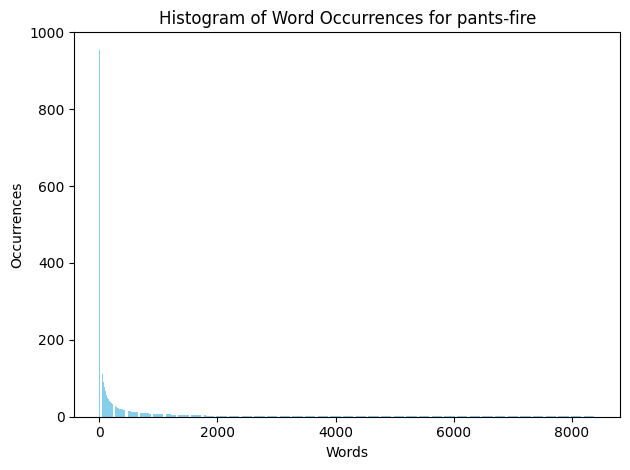

In [70]:
input_files = [
    "gdrive/MyDrive/true-words.csv",
    "gdrive/MyDrive/mostly-true-words.csv",
    "gdrive/MyDrive/half-true-words.csv",
    "gdrive/MyDrive/barely-true-words.csv",
    "gdrive/MyDrive/false-words.csv",
    "gdrive/MyDrive/pants-fire-words.csv"
]

# Output file paths
output_files = [
    "gdrive/MyDrive/true-histogram.png",
    "gdrive/MyDrive/mostly-true-histogram.png",
    "gdrive/MyDrive/half-true-histogram.png",
    "gdrive/MyDrive/barely-true-histogram.png",
    "gdrive/MyDrive/false-histogram.png",
    "gdrive/MyDrive/pants-fire-histogram.png"
]

for input_file, output_file in zip(input_files, output_files):
    if input_file == input_files[0]:
        label = "TRUE"
    elif input_file == input_files[1]:
        label = "mostly-true"
    elif input_file == input_files[2]:
        label = "half-true"
    elif input_file == input_files[3]:
        label = "barely-true"
    elif input_file == input_files[4]:
        label = "FALSE"
    elif input_file == input_files[5]:
        label = "pants-fire"
    
    df = pd.read_csv(input_file)
    
    tokenized_statements = [token for sublist in df["Tokenized Statement"] for token in eval(sublist)]
    
    word_counts = pd.Series(tokenized_statements).value_counts()
  
    plt.bar(range(len(word_counts)), word_counts.values, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Occurrences')
    plt.title(f'Histogram of Word Occurrences for {label}')
    plt.ylim(0, 1000)
    plt.tight_layout()
    
    plt.savefig(output_file)